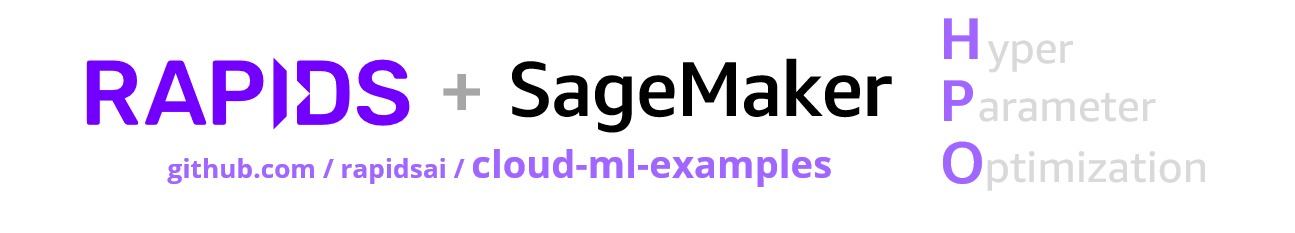<img src='img/header.png'>

[Hyper Parameter Optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization) (HPO) improves model quality by searching over hyperparameters, parameters not typically learned during the training process but rather values that control the learning process itself (e.g., model size/capacity). This search can significantly boost model quality relative to default settings and non-expert tuning; however, HPO can take a very long time on a non-accelerated platform. In this notebook, we containerize a RAPIDS workflow and run Bring-Your-Own-Container SageMaker HPO to show how we can overcome the computational complexity of model search. 

We accelerate HPO in two key ways: 
* by *scaling within a node* (e.g., multi-GPU where each GPU brings a magnitude higher core count relative to CPUs), and 
* by *scaling across nodes* and running parallel trials on cloud instances.

By combining these two powers HPO experiments that feel unapproachable and may take multiple days on CPU instances can complete in just hours. For example, we find a <span style="color:#8735fb; font-size:14pt"> **12x** </span> speedup in wall clock time (6 hours vs 3+ days) and a <span style="color:#8735fb; font-size:14pt"> **4.5x** </span> reduction in cost when comparing between GPU and CPU [EC2 Spot instances](https://docs.aws.amazon.com/sagemaker/latest/dg/model-managed-spot-training.html) on 100 XGBoost HPO trials using 10 parallel workers on 10 years of the Airline Dataset (~63M flights) hosted in a S3 bucket. For additional details refer to the <a href='#experiments'>end of the notebook</a>.

With all these powerful tools at our disposal, every data scientist should feel empowered to up-level their model before serving it to the world!

<img src='img/hpo.png'>

<span style="color:#8735fb; font-size:22pt"> **Preamble** </span>

To get things rolling let's make sure we can query our AWS SageMaker execution role and session as well as our account ID and AWS region.

In [1]:
!docker images

REPOSITORY   TAG       IMAGE ID   CREATED   SIZE


In [2]:
%pip install --upgrade boto3

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sagemaker
from helper_functions import *

In [4]:
execution_role = sagemaker.get_execution_role()
session = sagemaker.Session()

account=!(aws sts get-caller-identity --query Account --output text)
region=!(aws configure get region)

In [5]:
account, region

(['561241433344'], ['us-west-2'])

<span style="color:#8735fb; font-size:22pt"> **Key Choices** </span>

Let's go ahead and choose the configuration options for our HPO run.

Below are two reference configurations showing a small and a large scale HPO (sized in terms of total experiments/compute). 

The default values in the notebook are set for the small HPO configuration, however you are welcome to scale them up.

> **small HPO**: 1_year, XGBoost, 3 CV folds, singleGPU, max_jobs = 10, max_parallel_jobs = 2

> **large HPO**: 10_year, XGBoost, 10 CV folds, multiGPU, max_jobs = 100, max_parallel_jobs = 10

<span style="color:#8735fb; font-size:18pt"> [ Dataset ] </span>

We offer free hosting for several demo datasets that you can try running HPO with, or alternatively you can bring your own dataset (BYOD). 

By default we leverage the `Airline` dataset, which is a large public tracker of US domestic flight logs which we offer in various sizes (1 year, 3 year, and 10 year) and in <a href='https://parquet.apache.org/'>Parquet</a> (compressed column storage) format. The machine learning objective with this dataset is to predict whether flights will be more than 15 minutes late arriving to their destination ([dataset link](https://www.transtats.bts.gov/DatabaseInfo.asp?DB_ID=120&DB_URL=), additional details in <a href='#dataset'>Section 1.1</a>). 

As an alternative we also offer the `NYC Taxi` dataset which captures yellow cab trip details in Ney York in January 2020, stored in <a href='https://en.wikipedia.org/wiki/Comma-separated_values'>CSV </a> format without any compression. The machine learning objective with this dataset is to predict whether a trip had an above average tip (>$2.20).

We host the demo datasets in public S3 demo buckets in both the **us-east-1** (N. Virginia) or **us-west-2** (Oregon) regions (i.e., `sagemaker-rapids-hpo-us-east-1`, and `sagemaker-rapids-hpo-us-west-2`). You should run the SageMaker HPO workflow in either of these two regions if you wish to leverage the demo datasets since SageMaker requires that the S3 dataset and the compute you'll be renting are co-located. 

Lastly, if you plan to use your own dataset refer to the <a href='#byod'>BYOD checklist in the Appendix</a> to help integrate into the workflow.

| dataset | data_bucket | dataset_directory | # samples | storage type | time span |
|---|---|---|---|---|---|
| Airline Stats Small    | demo    | 1_year   | 6.3M   | Parquet     | 2019         |
| Airline Stats Medium   | demo    | 3_year   | 18M    | Parquet     | 2019-2017    |
| Airline Stats Large    | demo    | 10_year  | 63M    | Parquet     | 2019-2010    |
| NYC Taxi               | demo    | NYC_taxi | 6.3M   | CSV         | 2020 January |
| Bring Your Own Dataset | custom  | custom   | custom | Parquet/CSV | custom       |

In [6]:
# please choose dataset S3 bucket and directory
data_bucket = 'sagemaker-rapids-hpo-' + region[0]
dataset_directory = '10_year' # '1_year', '3_year', '10_year', 'NYC_taxi'

# please choose output bucket for trained model(s)
model_output_bucket = session.default_bucket()

In [7]:
s3_data_input = f"s3://{data_bucket}/{dataset_directory}"
s3_model_output = f"s3://{model_output_bucket}/trained-models"

best_hpo_model_local_save_directory = os.getcwd()

<span style="color:#8735fb; font-size:18pt"> [ Algorithm ] </span>

From a ML/algorithm perspective, we offer [XGBoost](https://xgboost.readthedocs.io/en/latest/#), [RandomForest](https://docs.rapids.ai/api/cuml/stable/cuml_blogs.html#tree-and-forest-models) and [KMeans](https://docs.rapids.ai/api/cuml/stable/api.html?highlight=kmeans#cuml.KMeans). You are free to switch between these algorithm choices and everything in the example will continue to work.

In [8]:
# please choose learning algorithm
algorithm_choice = 'XGBoost'

assert (algorithm_choice in ['XGBoost', 'RandomForest', 'KMeans'])

We can also optionally increase robustness via reshuffles of the train-test split (i.e., [cross-validation folds](https://scikit-learn.org/stable/modules/cross_validation.html)). Typical values here are between 3 and 10 folds.

In [9]:
# please choose cross-validation folds
cv_folds = 10

assert (cv_folds >= 1)

<span style="color:#8735fb; font-size:18pt"> [ ML Workflow Compute Choice ] </span>

We enable the option of running different code variations that unlock increasing amounts of parallelism in the compute workflow. 

* `singleCPU`** = [pandas](https://pandas.pydata.org/) + [sklearn](https://scikit-learn.org/stable/)
* `multiCPU`   = [dask](https://dask.org/) + [pandas](https://pandas.pydata.org/) + [sklearn](https://scikit-learn.org/stable/)

* <span style="color:#8735fb; font-size:14pt"> RAPIDS </span> `singleGPU` = [cudf](https://github.com/rapidsai/cudf) + [cuml](https://github.com/rapidsai/cuml)
* <span style="color:#8735fb; font-size:14pt"> RAPIDS </span> `multiGPU`  = [dask](https://dask.org/) + [cudf](https://github.com/rapidsai/cudf) + [cuml](https://github.com/rapidsai/cuml) 

All of these code paths are available in the `/code/workflows` directory for your reference. 

> **Note that the single-CPU option will leverage multiple cores in the model training portion of the workflow; however, to unlock full parallelism in each stage of the workflow we use [Dask](https://dask.org/). 



In [10]:
# please choose code variant
ml_workflow_choice = 'multiGPU' 

assert (ml_workflow_choice in ['singleCPU', 'singleGPU', 'multiCPU', 'multiGPU'])

<span style="color:#8735fb; font-size:18pt"> [ Search Ranges and Strategy ] </span>
<a id='strategy-and-param-ranges'></a>

One of the most important choices when running HPO is to choose the bounds of the hyperparameter search process. Below we've set the ranges of the hyperparameters to allow for interesting variation, you are of course welcome to revise these ranges based on domain knowledge especially if you plan to plug in your own dataset. 

> Note that we support additional algorithm specific parameters (refer to the `parse_hyper_parameter_inputs` function in `HPOConfig.py`), but for demo purposes have limited our choice to the three parameters that overlap between the XGBoost and RandomForest algorithms. For more details see the documentation for [XGBoost parameters](https://xgboost.readthedocs.io/en/latest/parameter.html) and [RandomForest parameters](https://docs.rapids.ai/api/cuml/stable/api.html#random-forest). Since KMeans uses different parameters, we adjust accordingly.


In [11]:
# please choose HPO search ranges
hyperparameter_ranges = {
    'max_depth'    : sagemaker.parameter.IntegerParameter        ( 5, 15 ),
    'n_estimators' : sagemaker.parameter.IntegerParameter        ( 100, 500 ),
    'max_features' : sagemaker.parameter.ContinuousParameter     ( 0.1, 1.0 ),    
} # see note above for adding additional parameters

In [12]:
if 'XGBoost' in algorithm_choice: 
    # number of trees parameter name difference b/w XGBoost and RandomForest
    hyperparameter_ranges['num_boost_round'] = hyperparameter_ranges.pop('n_estimators')

In [13]:
if 'KMeans' in algorithm_choice:
    hyperparameter_ranges = {
        'n_clusters' : sagemaker.parameter.IntegerParameter     ( 2, 20 ), 
        'max_iter'   : sagemaker.parameter.IntegerParameter     ( 100, 500 ),
    }

We can also choose between a Random and Bayesian search strategy for picking parameter combinations. 

**Random Search**: Choose a random combination of values from within the ranges for each training job it launches. The choice of hyperparameters doesn't depend on previous results so you can run the maximum number of concurrent workers without affecting the performance of the search. 

**Bayesian Search**: Make a guess about which hyperparameter combinations are likely to get the best results. After testing the first set of hyperparameter values, hyperparameter tuning uses regression to choose the next set of hyperparameter values to test.

In [14]:
# please choose HPO search strategy
search_strategy = 'Random'

assert (search_strategy in ['Random', 'Bayesian'])

<span style="color:#8735fb; font-size:18pt"> [ Experiment Scale ] </span>

We also need to decide how may total experiments to run, and how many should run in parallel. Below we have a very conservative number of maximum jobs to run so that you don't accidently spawn large computations when starting out, however for meaningful HPO searches this number should be much higher (e.g., in our experiments we often run 100 max_jobs). Note that you may need to request a [quota limit increase](https://docs.aws.amazon.com/general/latest/gr/sagemaker.html) for additional  `max_parallel_jobs` parallel workers. 

In [15]:
# please choose total number of HPO experiments[ we have set this number very low to allow for automated CI testing ]
max_jobs = 100

In [16]:
# please choose number of experiments that can run in parallel
max_parallel_jobs = 10

Let's also set the max duration for an individual job to 24 hours so we don't have run-away compute jobs taking too long.

In [17]:
max_duration_of_experiment_seconds = 60 * 60 * 24

<span style="color:#8735fb; font-size:18pt"> [ Compute Platform ] </span>

Based on the dataset size and compute choice we will try to recommend an instance choice*, you are of course welcome to select alternate configurations. 
> e.g., For the 10_year dataset option, we suggest ml.p3.8xlarge instances (4 GPUs) and ml.m5.24xlarge CPU instances ( we will need upwards of 200GB CPU RAM during model training).

In [18]:
# we will recommend a compute instance type, feel free to modify
instance_type = recommend_instance_type(ml_workflow_choice, dataset_directory) 

recommended instance type : ml.p3.8xlarge 
instance details          : 4x GPUs [ V100 ], 64GB GPU memory,  244GB CPU memory


In addition to choosing our instance type, we can also enable significant savings by leveraging [AWS EC2 Spot Instances](https://aws.amazon.com/ec2/spot/).

We **highly recommend** that you set this flag to `True` as it typically leads to 60-70% cost savings. Note, however that you may need to request a [quota limit increase](https://docs.aws.amazon.com/general/latest/gr/sagemaker.html) to enable Spot instances in SageMaker.


In [19]:
# please choose whether spot instances should be used
use_spot_instances_flag = True

<span style="color:#8735fb; font-size:22pt"> **Validate** </span>

In [20]:
summarize_choices(s3_data_input, s3_model_output, ml_workflow_choice, algorithm_choice, 
                  cv_folds, instance_type, use_spot_instances_flag, search_strategy, 
                  max_jobs, max_parallel_jobs, max_duration_of_experiment_seconds)

s3 data input    =	s3://sagemaker-rapids-hpo-us-west-2/10_year
s3 model output  =	s3://sagemaker-us-west-2-561241433344/trained-models
compute          =	multiGPU
algorithm        =	XGBoost, 10 cv-fold
instance         =	ml.p3.8xlarge
spot instances   =	True
hpo strategy     =	Random
max_experiments  =	100
max_parallel     =	10
max runtime      =	86400 sec


<span style="display: block; text-align: center; color:#8735fb; font-size:30pt"> **1. ML Workflow** </span>

<img src='img/ml_workflow.png' width='800'> 

<span style="color:#8735fb; font-size:20pt"> 1.1 - Dataset </span>
<a id ='dataset'></a>

The default settings for this demo are built to utilize the Airline dataset (Carrier On-Time Performance 1987-2020, available from the [Bureau of Transportation Statistics](https://transtats.bts.gov/Tables.asp?DB_ID=120&DB_Name=Airline%20On-Time%20Performance%20Data&DB_Short_Name=On-Time#)). Below are some additional details about this dataset, we plan to offer a companion notebook that does a deep dive on the data science behind this dataset. Note that if you are using an alternate dataset (e.g., NYC Taxi or BYOData) these details are not relevant.

The public dataset contains logs/features about flights in the United States (17 airlines) including:

* Locations and distance  ( `Origin`, `Dest`, `Distance` )
* Airline / carrier ( `Reporting_Airline` )
* Scheduled departure and arrival times ( `CRSDepTime` and `CRSArrTime` )
* Actual departure and arrival times ( `DpTime` and `ArrTime` )
* Difference between scheduled & actual times ( `ArrDelay` and `DepDelay` )
* Binary encoded version of late, aka our target variable ( `ArrDelay15` )

Using these features we will build a classifier model to predict whether a flight is going to be more than 15 minutes late on arrival as it prepares to depart.

<span style="color:#8735fb; font-size:20pt"> 1.2 - Python ML Workflow </span>

To build a RAPIDS enabled SageMaker HPO we first need to build a [SageMaker Estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html). An Estimator is a container image that captures all the software needed to run an HPO experiment. The container is augmented with entrypoint code that will be trggered at runtime by each worker. The entrypoint code enables us to write custom models and hook them up to data. 

In order to work with SageMaker HPO, the entrypoint logic should parse hyperparameters (supplied by AWS SageMaker), load and split data, build and train a model, score/evaluate the trained model, and emit an output representing the final score for the given hyperparameter setting. We've already built multiple variations of this code.

If you would like to make changes by adding your custom model logic feel free to modify the **train.py** and/or the specific workflow files in the `code/workflows` directory. You are also welcome to uncomment the cells below to load the read/review the code.

First, let's switch our working directory to the location of the Estimator entrypoint and library code.

In [21]:
%cd code

/home/ec2-user/SageMaker/cloud-ml-examples/aws/code


In [22]:
# %load train.py

In [23]:
# %load workflows/MLWorkflowSingleGPU.py

<span style="display: block; text-align: center; color:#8735fb; font-size:30pt"> **2. Build Estimator** </span>

<img src='img/estimator.png' width='800'>

As we've already mentioned, the SageMaker Estimator represents the containerized software stack that AWS SageMaker will replicate to each worker node.

The first step to building our Estimator, is to augment a RAPIDS container with our ML Workflow code from above, and push this image to Amazon Elastic Cloud Registry so it is available to SageMaker.


<span style="color:#8735fb; font-size:20pt"> 2.1 - Containerize and Push to ECR </span>

Now let's turn to building our container so that it can integrate with the AWS SageMaker HPO API.

Our container can either be built on top of the latest RAPIDS [ nightly ] image as a starting layer or the RAPIDS stable image.


In [24]:
rapids_base_container = 'rapidsai/rapidsai-core:22.12-cuda11.5-runtime-ubuntu18.04-py3.9'

Let's also decide on the full name of our container.

In [25]:
image_base = 'rapids-sagemaker-mnmg-100'
image_tag  = rapids_base_container.split(':')[1]

In [26]:
ecr_fullname = f"{account[0]}.dkr.ecr.{region[0]}.amazonaws.com/{image_base}:{image_tag}"

In [27]:
ecr_fullname

'561241433344.dkr.ecr.us-west-2.amazonaws.com/rapids-sagemaker-mnmg-100:22.12-cuda11.5-runtime-ubuntu18.04-py3.9'

<span style="color:#8735fb; font-size:18pt"> 2.1.1 - Write Dockerfile </span>

We write out the Dockerfile to disk, and in a few cells execute the docker build command. 


Let's now write our selected RAPDIS image layer as the first FROM statement in the the Dockerfile.

In [28]:
with open('Dockerfile', 'w') as dockerfile: 
    dockerfile.writelines( f'FROM {rapids_base_container} \n\n'
                           f'ENV AWS_DATASET_DIRECTORY="{dataset_directory}"\n'
                           f'ENV AWS_ALGORITHM_CHOICE="{algorithm_choice}"\n'
                           f'ENV AWS_ML_WORKFLOW_CHOICE="{ml_workflow_choice}"\n'
                           f'ENV AWS_CV_FOLDS="{cv_folds}"\n')

Next let's append write the remaining pieces of the Dockerfile, namely adding the sagemaker-training-toolkit, flask, dask-ml, and copying our python code.

In [29]:
%%writefile -a Dockerfile

# ensure printed output/log-messages retain correct order
ENV PYTHONUNBUFFERED=True
    
# add sagemaker-training-toolkit [ requires build tools ], flask [ serving ], and dask-ml
RUN apt-get update && apt-get install -y --no-install-recommends build-essential \ 
    && source activate rapids \
    && pip3 install sagemaker-training cupy-cuda115 flask dask-ml \
    && pip3 install --upgrade protobuf

# path where SageMaker looks for code when container runs in the cloud
ENV CLOUD_PATH="/opt/ml/code"

# copy our latest [local] code into the container 
COPY . $CLOUD_PATH

# make the entrypoint script executable
RUN chmod +x $CLOUD_PATH/entrypoint.sh

WORKDIR $CLOUD_PATH
ENTRYPOINT ["./entrypoint.sh"]

Appending to Dockerfile


Lastly, let's ensure that our Dockerfile correctly captured our base image selection.

In [ ]:
validate_dockerfile(rapids_base_container)
!cat Dockerfile

<span style="color:#8735fb; font-size:18pt"> 2.1.2 Build and Tag </span>

The build step will be dominated by the download of the RAPIDS image (base layer). If it's already been downloaded the build will take less than 1 minute.

In [30]:
!docker pull $rapids_base_container

22.12-cuda11.5-runtime-ubuntu18.04-py3.9: Pulling from rapidsai/rapidsai-core

e5416296: Pulling fs layer 
2d3ed59c: Pulling fs layer 
1b38369f: Pulling fs layer 
4c8e4d7e: Pulling fs layer 
a06239d6: Pulling fs layer 
cb87b249: Pulling fs layer 
61c55367: Pulling fs layer 
fb9847e6: Pulling fs layer 
0cc4d9ef: Pulling fs layer 
Digest: sha256:959a2e80642e881ef99705473d95165cda8383543cff4ae5ca554da782021e47KExtracting   2.96GB/3.932GB
Status: Downloaded newer image for rapidsai/rapidsai-core:22.12-cuda11.5-runtime-ubuntu18.04-py3.9
docker.io/rapidsai/rapidsai-core:22.12-cuda11.5-runtime-ubuntu18.04-py3.9


In [31]:
!docker images

REPOSITORY               TAG                                        IMAGE ID       CREATED       SIZE
rapidsai/rapidsai-core   22.12-cuda11.5-runtime-ubuntu18.04-py3.9   9de590bd08c5   5 weeks ago   13.1GB


In [32]:
%%time
!docker build . -t $ecr_fullname -f Dockerfile

Sending build context to Docker daemon  90.62kB
Step 1/12 : FROM rapidsai/rapidsai-core:22.12-cuda11.5-runtime-ubuntu18.04-py3.9
 ---> 9de590bd08c5
Step 2/12 : ENV AWS_DATASET_DIRECTORY="10_year"
 ---> Running in 4b7c02990c9d
Removing intermediate container 4b7c02990c9d
 ---> 967f657cfc72
Step 3/12 : ENV AWS_ALGORITHM_CHOICE="XGBoost"
 ---> Running in d6dbf287ed0f
Removing intermediate container d6dbf287ed0f
 ---> 114a69f1a302
Step 4/12 : ENV AWS_ML_WORKFLOW_CHOICE="multiGPU"
 ---> Running in bfe707fe38f9
Removing intermediate container bfe707fe38f9
 ---> 00c743a5a456
Step 5/12 : ENV AWS_CV_FOLDS="10"
 ---> Running in bb2a2f2a1a7e
Removing intermediate container bb2a2f2a1a7e
 ---> ce9a5ab0fb1e
Step 6/12 : ENV PYTHONUNBUFFERED=True
 ---> Running in d396568a5cab
Removing intermediate container d396568a5cab
 ---> 1c75cb5d8dee
Step 7/12 : RUN apt-get update && apt-get install -y --no-install-recommends build-essential     && source activate rapids     && pip3 install sagemaker-training cup

In [33]:
!docker images

REPOSITORY                                                               TAG                                        IMAGE ID       CREATED                  SIZE
561241433344.dkr.ecr.us-west-2.amazonaws.com/rapids-sagemaker-mnmg-100   22.12-cuda11.5-runtime-ubuntu18.04-py3.9   045f00216761   Less than a second ago   13.7GB
rapidsai/rapidsai-core                                                   22.12-cuda11.5-runtime-ubuntu18.04-py3.9   9de590bd08c5   5 weeks ago              13.1GB


<span style="color:#8735fb; font-size:18pt"> 2.1.3 - Publish to Elastic Cloud Registry (ECR) </span>

Now that we've built and tagged our container its time to push it to Amazon's container registry (ECR). Once in ECR, AWS SageMaker will be able to leverage our image to build Estimators and run experiments.


Docker Login to ECR

In [35]:
docker_login_str = !(aws ecr get-login --region {region[0]} --no-include-email)

In [36]:
!{docker_login_str[0]}

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


Create ECR repository [ if it doesn't already exist]

In [37]:
repository_query = !(aws ecr describe-repositories --repository-names $image_base)
if repository_query[0] == '':
    !(aws ecr create-repository --repository-name $image_base)

Let's now actually push the container to ECR
> Note the first push to ECR may take some time (hopefully less than 10 minutes).

In [38]:
!docker push $ecr_fullname

The push refers to repository [561241433344.dkr.ecr.us-west-2.amazonaws.com/rapids-sagemaker-mnmg-100]

36e5943b: Preparing 
61737e1c: Preparing 
b2094ffc: Preparing 
601675bf: Preparing 
a211643c: Preparing 
51d8b000: Preparing 
f7b7f229: Preparing 
48598b79: Preparing 
2b6403fc: Preparing 
ca9f5267: Preparing 
e36e26b2: Preparing 
2c4843ad: Preparing 
2094ffc: Pushed   588.6MB/583.5MB2A22.12-cuda11.5-runtime-ubuntu18.04-py3.9: digest: sha256:1d0c31e38929d70278bc2170206ad74207dd692dc7b4ff125de1d6c924fe0afe size: 3061


<span style="color:#8735fb; font-size:20pt"> 2.2 - Create Estimator </span>

Having built our container [ +custom logic] and pushed it to ECR, we can finally compile all of efforts into an Estimator instance.

In [39]:
!docker images 

REPOSITORY                                                               TAG                                        IMAGE ID       CREATED              SIZE
561241433344.dkr.ecr.us-west-2.amazonaws.com/rapids-sagemaker-mnmg-100   22.12-cuda11.5-runtime-ubuntu18.04-py3.9   045f00216761   About a minute ago   13.7GB
rapidsai/rapidsai-core                                                   22.12-cuda11.5-runtime-ubuntu18.04-py3.9   9de590bd08c5   5 weeks ago          13.1GB


In [40]:
# 'volume_size' - EBS volume size in GB, default = 30
estimator_params = {
    'image_uri': ecr_fullname,
    'role': execution_role,    
    
    'instance_type': instance_type,
    'instance_count': 2,
    
    'input_mode': 'File',
    'output_path': s3_model_output,
    
    'use_spot_instances': use_spot_instances_flag,
    
    'max_run': max_duration_of_experiment_seconds, # 24 hours 
    'sagemaker_session': session,
}

if use_spot_instances_flag == True:
    estimator_params.update({'max_wait' : max_duration_of_experiment_seconds + 1})

In [41]:
estimator = sagemaker.estimator.Estimator(**estimator_params)

<span style="color:#8735fb; font-size:20pt"> 2.3 - Test Estimator </span>

Now we are ready to test by asking SageMaker to run the BYOContainer logic inside our Estimator. This is a useful step if you've made changes to your custom logic and are interested in making sure everything works before launching a large HPO search. 

> Note: This verification step will use the default hyperparameter values declared in our custom train code, as SageMaker HPO will not be orchestrating a search for this single run.

In [42]:
summarize_choices(s3_data_input, s3_model_output, ml_workflow_choice, algorithm_choice, 
                  cv_folds, instance_type, use_spot_instances_flag, search_strategy, 
                  max_jobs, max_parallel_jobs, max_duration_of_experiment_seconds )

s3 data input    =	s3://sagemaker-rapids-hpo-us-west-2/10_year
s3 model output  =	s3://sagemaker-us-west-2-561241433344/trained-models
compute          =	multiGPU
algorithm        =	XGBoost, 10 cv-fold
instance         =	ml.p3.8xlarge
spot instances   =	True
hpo strategy     =	Random
max_experiments  =	100
max_parallel     =	10
max runtime      =	86400 sec


In [43]:
job_name = new_job_name_from_config(dataset_directory, region, ml_workflow_choice, 
                                    algorithm_choice, cv_folds,
                                    instance_type  )

generated job name : air-mGPU-XGB-10cv-a96aa65a146b7a



In [44]:
estimator.fit(inputs = s3_data_input, job_name = job_name.lower())

INFO:sagemaker:Creating training-job with name: air-mgpu-xgb-10cv-a96aa65a146b7a


2023-01-23 18:33:19 Starting - Starting the training job......
2023-01-23 18:34:13 Starting - Preparing the instances for training............
2023-01-23 18:36:00 Downloading - Downloading input data...
2023-01-23 18:36:31 Training - Downloading the training image.....................
2023-01-23 18:39:52 Training - Training image download completed. Training in progress..@ entrypoint -> launching training script 
2023-01-23 18:40:14,715     INFO hpo_log 
parsing configuration from environment settings...
2023-01-23 18:40:14,715     INFO hpo_log   Dataset: Airline
  Compute: multi-GPU
  Algorithm: XGBoost
  CV_folds: 10
2023-01-23 18:40:14,715     INFO hpo_log parsing model hyperparameters from command line arguments...log
2023-01-23 18:40:14,720     INFO hpo_log {    'gamma': 0.0,
     'lambda': 1,
     'learning_rate': 0.3,
     'max_depth': 5,
     'num_boost_round': 10,
     'objective': 'binary:logistic',
     'random_state': 0,
     'seed': 0,
     'tree_method': 'gpu_hist',
     

<span style="display: block; text-align: center; color:#8735fb; font-size:30pt"> **3. Run HPO** </span>

With a working SageMaker Estimator in hand, the hardest part is behind us. In the key choices section we <a href='#strategy-and-param-ranges'>already defined our search strategy and hyperparameter ranges</a>, so all that remains is to choose a metric to evaluate performance on. For more documentation check out the AWS SageMaker [Hyperparameter Tuner documentation](https://sagemaker.readthedocs.io/en/stable/tuner.html).

<img src='img/run_hpo.png'>

<span style="color:#8735fb; font-size:20pt"> 3.1 - Define Metric </span>

We only focus on a single metric, which we call 'final-score', that captures the accuracy of our model on the test data unseen during training. You are of course welcome to add aditional metrics, see [AWS SageMaker documentation on Metrics](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-define-metrics.html). When defining a metric we provide a regular expression (i.e., string parsing rule) to extract the key metric from the output of each Estimator/worker.

In [55]:
metric_definitions = [{'Name': 'final-score', 'Regex': 'final-score: (.*);'}]

In [56]:
objective_metric_name = 'final-score'

<span style="color:#8735fb; font-size:20pt"> 3.2 - Define Tuner </span>

Finally we put all of the elements we've been building up together into a HyperparameterTuner declaration. 

In [57]:
hpo = sagemaker.tuner.HyperparameterTuner(estimator=estimator,
                                          metric_definitions=metric_definitions, 
                                          objective_metric_name=objective_metric_name,
                                          objective_type='Maximize',
                                          hyperparameter_ranges=hyperparameter_ranges,
                                          strategy=search_strategy,  
                                          max_jobs=max_jobs,
                                          max_parallel_jobs=max_parallel_jobs)

<span style="color:#8735fb; font-size:20pt"> 3.3 - Run HPO </span>

In [58]:
summarize_choices( s3_data_input, s3_model_output, ml_workflow_choice, algorithm_choice, 
                   cv_folds, instance_type, use_spot_instances_flag, search_strategy, 
                   max_jobs, max_parallel_jobs, max_duration_of_experiment_seconds )

s3 data input    =	s3://sagemaker-rapids-hpo-us-west-2/10_year
s3 model output  =	s3://sagemaker-us-west-2-561241433344/trained-models
compute          =	multiGPU
algorithm        =	XGBoost, 10 cv-fold
instance         =	ml.p3.8xlarge
spot instances   =	True
hpo strategy     =	Random
max_experiments  =	100
max_parallel     =	10
max runtime      =	86400 sec


Let's be sure we take a moment to confirm before launching all of our HPO experiments. Depending on your configuration options running this cell can kick off a massive amount of computation!
> Once this process begins, we recommend that you use the SageMaker UI to keep track of the <a href='../img/gpu_hpo_100x10.png'>health of the HPO process and the individual workers</a>.

In [60]:
# tuning_job_name = new_job_name_from_config(dataset_directory, region, ml_workflow_choice, 
#                                            algorithm_choice, cv_folds, 
# #                                            instance_type)
# hpo.fit( inputs=s3_data_input,
#          job_name=tuning_job_name,
#          wait=True,
#          logs='All')

# hpo.wait()  # block until the .fit call above is completed

<span style="color:#8735fb; font-size:20pt"> 3.4 - Results and Summary </span>

Once your job is complete there are multiple ways to analyze the results.
Below we display the performance of the best job, as well printing each HPO trial/job as a row of a dataframe.

In [61]:
tuning_job_name= 'air-mGPU-XGB-10cv-527fd372fa4d8d'

In [62]:
hpo_results = summarize_hpo_results(tuning_job_name)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


best score: 0.9203665256500244
best params: {'max_depth': '7', 'max_features': '0.29751893065195945', 'num_boost_round': '346'}
best job-name: air-mGPU-XGB-10cv-527fd372fa4d8d-042-ed1ff13b


In [63]:
sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name).dataframe()

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


,max_depth,max_features,num_boost_round,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,5.0,0.715196,116.0,air-mGPU-XGB-10cv-527fd372fa4d8d-100-c04c691b,Completed,0.920362,2023-01-23 21:01:38+00:00,2023-01-23 21:06:21+00:00,283.0
1,12.0,0.855974,243.0,air-mGPU-XGB-10cv-527fd372fa4d8d-099-97d44628,Completed,0.920355,2023-01-23 21:17:56+00:00,2023-01-23 21:22:34+00:00,278.0
2,11.0,0.549247,395.0,air-mGPU-XGB-10cv-527fd372fa4d8d-098-e74f483f,Completed,0.920356,2023-01-23 20:56:06+00:00,2023-01-23 21:00:44+00:00,278.0
3,7.0,0.882803,179.0,air-mGPU-XGB-10cv-527fd372fa4d8d-097-50755cd6,Completed,0.920356,2023-01-23 20:54:35+00:00,2023-01-23 20:59:13+00:00,278.0
4,8.0,0.416939,267.0,air-mGPU-XGB-10cv-527fd372fa4d8d-096-5c95eb2f,Completed,0.920355,2023-01-23 20:51:24+00:00,2023-01-23 20:56:02+00:00,278.0
...,...,...,...,...,...,...,...,...,...
95,5.0,0.426204,330.0,air-mGPU-XGB-10cv-527fd372fa4d8d-005-7b755a81,Completed,0.920355,2023-01-23 18:48:35+00:00,2023-01-23 18:53:48+00:00,313.0
96,5.0,0.283752,256.0,air-mGPU-XGB-10cv-527fd372fa4d8d-004-e4d086fb,Completed,0.920356,2023-01-23 18:48:34+00:00,2023-01-23 18:53:47+00:00,313.0
97,5.0,0.137874,377.0,air-mGPU-XGB-10cv-527fd372fa4d8d-003-89cd8506,Completed,0.920355,2023-01-23 18:48:31+00:00,2023-01-23 18:53:44+00:00,313.0
98,15.0,0.934718,365.0,air-mGPU-XGB-10cv-527fd372fa4d8d-002-caf8f6c3,Completed,0.920360,2023-01-23 18:48:25+00:00,2023-01-23 18:53:48+00:00,323.0


 For a more in depth look at the HPO process we invite you to check out the <a href='https://github.com/awslabs/amazon-sagemaker-examples/tree/master/hyperparameter_tuning/analyze_results'>HPO_Analyze_TuningJob_Results.ipynb</a> notebook which shows how we can explore interesting things like the <a href='img/results_analysis.png'>impact of each individual hyperparameter on the performance metric</a>.

<span style="color:#8735fb; font-size:20pt"> 3.5 - Getting the best Model </span>

Next let's download the best trained model from our HPO runs.

In [64]:
local_filename, s3_path_to_best_model = download_best_model(model_output_bucket, s3_model_output,
                                                            hpo_results, best_hpo_model_local_save_directory)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Successfully downloaded best model
> filename: /home/ec2-user/SageMaker/cloud-ml-examples/aws/best_model.tar.gz
> local directory : /home/ec2-user/SageMaker/cloud-ml-examples/aws

full S3 path : s3://sagemaker-us-west-2-561241433344/trained-models/air-mGPU-XGB-10cv-527fd372fa4d8d-042-ed1ff13b/output/model.tar.gz


<span style="color:#8735fb; font-size:20pt"> 3.6 - Model Serving </span>

With your best model in hand, you can now move on to [serving this model on SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-deployment.html). 

In the example below we show you how to build a [RealTimePredictor](https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html) using the best model found during the HPO search. We will add a lightweight Flask server to our RAPIDS Estimator (a.k.a., container) which will handle the incoming requests and pass them along to the trained model for inference. If you are curious about how this works under the hood check out the [Use Your Own Inference Server](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-inference-code.html) documentation and reference the code in `code/serve.py`.

If you are interested in additional serving options (e.g., large batch with batch-transform), we plan to add a companion notebook that will provide additional details.

<span style="color:#8735fb; font-size:18pt"> 3.6.1 - GPU serving </span>

In [65]:
endpoint_model = sagemaker.model.Model(image_uri=ecr_fullname, 
                                       role=execution_role, 
                                       model_data=s3_path_to_best_model)

In [66]:
ecr_fullname

'561241433344.dkr.ecr.us-west-2.amazonaws.com/rapids-sagemaker-mnmg-100:22.12-cuda11.5-runtime-ubuntu18.04-py3.9'

Kick off an instance for prediction [ recommend 'ml.g4dn.2xlarge' ]

In [67]:
DEMO_SERVING_FLAG = True

if DEMO_SERVING_FLAG:
    endpoint_model.deploy(initial_instance_count=1,
                          instance_type='ml.g4dn.2xlarge')  #'ml.p3.2xlarge'

INFO:sagemaker:Creating model with name: rapids-sagemaker-mnmg-100-2023-01-23-22-24-22-008
INFO:sagemaker:Creating endpoint-config with name rapids-sagemaker-mnmg-100-2023-01-23-22-24-22-498
INFO:sagemaker:Creating endpoint with name rapids-sagemaker-mnmg-100-2023-01-23-22-24-22-498


---------!

Perform the prediction and return the result(s).

Below we've compiled examples to sanity test the trained model performance on the Airline dataset.
> The first example is from a 2019 flight that departed nine minutes early, 

> The second example is from a 2018 flight that was more than two hours late to depart.

When we run these samples we expect to see **b'[0.0, 1.0]** as the printed result.

We encourage you to modify the queries below especially if you plug in your own dataset.

In [68]:
if DEMO_SERVING_FLAG:
    
    predictor = sagemaker.predictor.Predictor(
        endpoint_name=str(endpoint_model.endpoint_name), 
        sagemaker_session=session
    )

    if dataset_directory in ['1_year', '3_year', '10_year']:
        on_time_example = [2019.0, 4.0, 12.0, 2.0, 3647.0, 20452.0, 30977.0, 33244.0, 1943.0, -9.0, 0.0, 75.0, 491.0] # 9 minutes early departure
        late_example = [2018.0, 3.0, 9.0, 5.0, 2279.0, 20409.0, 30721.0, 31703.0, 733.0, 123.0, 1.0, 61.0, 200.0]
        example_payload = str(list([on_time_example, late_example]))
    else:
        example_payload = '' # fill in a sample payload
    
    result = predictor.predict(example_payload)
    print( result )

b'[0.0, 1.0]'


Once we are finished with the serving example, we should be sure to clean up and delete the endpoint. 

In [69]:
# if DEMO_SERVING_FLAG:
    
#     predictor.delete_endpoint()

<span style="color:#8735fb; font-size:25pt"> **Summary** </span>

We've now successfully built a RAPIDS ML workflow, containerized it (as a SageMaker Estimator), and launched a set of HPO experiments to find the best hyperparamters for our model.

If you are curious to go further, we invite you to plug in your own dataset and tweak the configuration settings to find your champion model!

**HPO Experiment Details**
<a id='experiments'></a>

As mentioned in the introduction we find a <span style="color:#8735fb; font-size:14pt"> **12X** </span> speedup in wall clock time and a <span style="color:#8735fb; font-size:14pt"> **4.5x** </span> reduction in cost when comparing between GPU and CPU instances on 100 HPO trials using 10 parallel workers on 10 years of the Airline Dataset (~63M flights). In these experiments we used the XGBoost algorithm with the multi-GPU vs multi-CPU Dask cluster and 10 cross validaiton folds. Below we offer a table with additional details.

<img src='img/results.png' width='70%'>

In the case of the CPU runs, 12 jobs were stopped since they exceeded the 24 hour limit we set. <a href='img/cpu_hpo_100x10.png'>CPU Job Summary Image</a>

In the case of the GPU runs, no jobs were stopped. <a href='img/gpu_hpo_100x10.png'>GPU Job Summary Image</a>

Note that in both cases 1 job failed because a spot instance was terminated. But 1 failed job out of 100 is a minimal tradeoff for the significant cost savings.

# Extension 1: SHAP Interpretability
# Extension 2: BringYourOwnDataset

<span style="display: block; color:#8735fb; font-size:25pt"> **Appendix: Bring Your Own Dataset Checklist** </span>
<a id ='byod'></a>

If you plan to use your own dataset (BYOD) here is a checklist to help you integrate into the workflow:

> - [ ] Dataset should be in either CSV or Parquet format.
> - [ ] Dataset is already pre-processed (and all feature-engineering is done).
> - [ ] Dataset is uploaded to S3 and `data_bucket` and `dataset_directory` have been set to the location of your data.
> - [ ] Dataset feature and target columns have been enumerated in `/code/HPODataset.py`


<span style="color:#8735fb; font-size:25pt"> **Rapids References** </span>

> [cloud-ml-examples](http://github.com/rapidsai/cloud-ml-examples)

> [RAPIDS HPO](https://rapids.ai/hpo)

> [cuML Documentation](https://docs.rapids.ai/api/cuml/stable/)

<span style="color:#8735fb; font-size:25pt"> **SageMaker References** </span>

> [SageMaker Training Toolkit](https://github.com/aws/sagemaker-training-toolkit)

> [Estimator Parameters](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html)

> Spot Instances [docs](https://docs.aws.amazon.com/sagemaker/latest/dg/model-managed-spot-training.html), and [blog]()